# DICOM network protocol

*Mark Thurston <mark.thurston@nhs.net>*

## Definitions

### DICOM

*Digital Imaging and Communications in Medicine (DICOM)* is an internationally agreed standard for the communication and management of medical imaging information and related data. This is a bit of a mouthful but, in simple terms, before DICOM, scanners of different brands were often not able to talk to each other or read files writen by other vendors' equipment.

DICOM, at least in theory, means we can use readily available software to download image data from other sources, whatever the brand of the system at the other end.

Unfortunately, due to the heterogeneity of the healthcare environment, the burden of supporting a huge range of legacy medical equipment, and some historical mistakes, the DICOM standard is incredibly complicated and different interpretations of the standard are common. Fortunately, you don't need to understand all of DICOM to be able to use parts of it effectively.

The aim of this high level guide is to introduce the user with some knowlege of networking, Linux, and Python but new to DICOM.

### Protocol

A *network protocol* defines how two computers (in this case, medical devices) communicate with each other in order to achieve specific tasks. The DICOM network protocol is a separate entity to the DICOM file type: this point can result in confusion for new users. The DICOM file format is separate and defines how medical imaging studies are stored on disk.

### PACS

A *picture archiving and communication system (PACS)* is the system medical healthcare professionals use to store and review medical images (including MRI, CT, X-ray, photos, etc). The term encompasses the server (storage) and the client (viewing) softare. In slightly confusing DICOM terminology, server and client are referred to as *service class provider (SCP)* and *service class user (SCU)* respectively.

## Client software

There are multiple software libraries and tools that are compliant with the DICOM standard and are able to talk DICOM and handle DICOM files, both commercial and open source.

These tools allow you to connect to another DICOM-compliant medical device (in our case, the PACS image archive) to perform a task:

* [DCMTK](https://dcmtk.org/)
* [GDCM](http://gdcm.sourceforge.net/wiki/index.php/Main_Page)
* [pynetdicom](https://pydicom.github.io/pynetdicom/stable/)

DCMTK and GDCM are freely available (including in the standard Debian/Ubuntu software repositories). DCMTK, developed by the German company OFFIS, is very mature. C/C++ libraries and command line DICOM applications (including Windows binaries) can be downloaded from the [OFFIS website](https://dcmtk.org/dcmtk.php.en). The man pages for DCMTK are well-written and extensive but many of the options are rarely used.

DCMTK command line examples will be followed by longer *pynetdicom* equivalents. Pynetdicom available in the [pypi repository](https://pypi.org/project/pynetdicom/) and can be freely installed using pip (as we will see next).

## Installing the Python DICOM network library

The Python package manager `pip` allows you to install an additional Python module for use later on. Pynetdicom should already be installed on this system but this is the command you need to run to use it on your own system:

In [ ]:
!python -m pip install pynetdicom

## Open access DICOM servers

Although DICOM is a ratified standard, it's complexity makes it harder to understand and, perhaps, not as robust as other standards (C and HTTP). There are many different interpretations and certain features may not be implemented or are implemented differently. However, openly available DICOM servers are still useful for creating a lab environment (even if differences may become apparent when compared to commercial software).

### Medical Connections

Medical Connections is a Swansea-based software company created by the late radiologist and former DICOM committee member, Dr Dave Harvey (a pioneer in the development of DICOM). Medical Connections make available on the public internet a [DICOM server](https://www.dicomserver.co.uk/) that anyone can access for education and testing purposes.

We will use *dicomserver.co.uk* in this notebook.

### Orthanc 

[Orthanc](https://www.orthanc-server.com/) is an open source DICOM server developed by University Hospital of Liège, Belgium. It is under active development and packages are available in the standard Debian/Ubuntu repositories. It works well for a lab environment but requires additional set-up time.

University Hospitals Plymouth run Orthanc as a secondary PACS, for storage of non-diagnostic X-ray images for teaching purposes.

## dicomserver.co.uk

We are going to connect to the [Medical Connections DICOM server](https://www.dicomserver.co.uk).

First, check your network connection with a ICMP ping request to confirm that you can reach the PACS server:

In [2]:
# connection settings from https://www.dicomserver.co.uk
REMOTE_SERVER = 'www.dicomserver.co.uk'
REMOTE_PORT = 11112

!ping -c1 {REMOTE_SERVER} >/dev/null && echo Success || echo Failure

Success


## C-ECHO request (dcmtk)

The most basic DICOM network command is *C-ECHO*. Essentially, this is one device making DICOM contact with another device and asking for a response. For those familiar with networking, it has similarities to an ICMP ping request but, in modern DICOM devices, takes place higher up in the TCP/IP stack.

If *C-ECHO* doesn't work, it is highly unlikely you will be able to get other DICOM commands to work, so it's best to try this first.

Without the `--verbose` flag, there is no output (just a return value), so you need to test for this. More information available at `man echoscu`. 

In [ ]:
! echoscu {REMOTE_SERVER} {REMOTE_PORT} --verbose && echo Success || echo Failure

## C-ECHO request (pynetdicom)

The [pynetdicom documentation](https://pydicom.github.io/pynetdicom/stable/tutorials/create_scu.html#create-an-application-entity-and-associate) shows how to create a basic *C-ECHO* request:

In [ ]:
from pynetdicom import AE, debug_logger
from pynetdicom.sop_class import VerificationSOPClass

ae = AE()
# https://www.dicomlibrary.com/dicom/sop/
ae.add_requested_context(VerificationSOPClass)
assoc = ae.associate(REMOTE_SERVER, REMOTE_PORT)

if assoc.is_established:
    print('Association established with Echo SCP')
    assoc.release()
else:
    # Association rejected, aborted or never connected
    print('Failed to associate')

## C-FIND request (dcmtk)

*C-FIND* is used to search the DICOM server, e.g. for a patient, or for a study, or for a series within a study. Functionality could be compared to an SQL query or, for those familiar with web APIs, a HTTP GET request but the interface is quite a lot less sophisticated and, perhaps, less intuitive.

As a side note, implementations are likely to use SQL behind the scenes. Some modern DICOM servers provide a [web API interface](https://en.wikipedia.org/wiki/DICOMweb) in addition to the DICOM interface.

*C-FIND* is easiest to understand using DCMTK on the command line. This is probably the most basic *C-FIND* example, searching for all patients matching the name (*PatientName*) Joe Bloggs:

In [ ]:
! findscu {REMOTE_SERVER} {REMOTE_PORT} \
    --patient \
    --key PatientName='Bloggs^Joe' --key QueryRetrieveLevel='PATIENT' \
    --key PatientID # including an empty key will fetch the value in the output

### DICOM dictionary values

A [full list](https://dicomlibrary.com/dicom/dicom-tags/) of DICOM tags and corresponding numbers (think *hash table keys*) is available for reference.

You can use the equivalent numerical value for the tag in your search instead, so this code is equivalent:

In [ ]:
! findscu {REMOTE_SERVER} {REMOTE_PORT} \
    --patient \
    --key 10,10='Bloggs^Joe' --key 8,52='PATIENT' \
    --key 10,20 # (10,20) = PatientID

## C-FIND request (pynetdicom)

Performing a C-FIND query in Python requires more legwork:

In [ ]:
from pynetdicom import AE
from pynetdicom.sop_class import PatientRootQueryRetrieveInformationModelFind
from pydicom.dataset import Dataset

ae = AE()
ae.add_requested_context(PatientRootQueryRetrieveInformationModelFind)

ds = Dataset()
ds.PatientName = 'BLOGGS^JOE'
ds.QueryRetrieveLevel = 'PATIENT'
ds.PatientID = ''

# Associate with the peer AE at IP 127.0.0.1 and port 11112
assoc = ae.associate(REMOTE_SERVER, REMOTE_PORT)
if assoc.is_established:
    # Send the C-FIND request
    responses = assoc.send_c_find(ds, PatientRootQueryRetrieveInformationModelFind)
    for (status, identifier) in responses:
        if status:
            print('C-FIND query status: 0x{0:04X}'.format(status.Status))
            print(f'Reponse: {identifier}')
        else:
            print('Connection timed out, was aborted or received invalid response')
    # Release the association
    assoc.release()
else:
    print('Association rejected, aborted or never connected')

## Query-retrieve (dcmtk)

This is the DICOM terminology for a finding an event and fetching the data associated with it (including pixel data). For research dataset acquisition, this is repeated for each study.

Once you have found the patient, you need to find all the studies for that patient and select the one that you want (ideally by unique identifier).

C-MOVE or C-GET can both be used for image download. C-MOVE is generally preferred because it is more flexible.

In [27]:
# create temp dir, if not already there
import os
OUTPUT_DIR = os.path.join(os.path.expanduser('~'), 'tmp')
! [ ! -d {OUTPUT_DIR} ] && mkdir {OUTPUT_DIR}

# find the patient details, by name
! findscu {REMOTE_SERVER} {REMOTE_PORT} \
    --patient \
    --key 8,52='PATIENT' --key 10,10='Bloggs^Joe' \
    --key 10,20 --output-directory {OUTPUT_DIR} --extract

# all studies for the above patient that happened on 31/3/2020
! findscu {REMOTE_SERVER} {REMOTE_PORT} \
    -O \
    --key QueryRetrieveLevel=STUDY \
    --key StudyInstanceUID --key StudyDate=20200331 \
    "{OUTPUT_DIR}"/*.dcm --output-directory {OUTPUT_DIR} --extract

# download the study - using C-MOVE
! movescu {REMOTE_SERVER} {REMOTE_PORT} \
    --port {REMOTE_PORT} --move MOVESCU --call MOVESCU \
    "{OUTPUT_DIR}"/*.dcm --output-directory {OUTPUT_DIR}

## Query-retrieve (pynetdicom)

'DICOM network protocol.ipynb'


## Display some of the retrieved image data

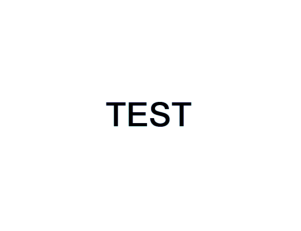

In [66]:
import matplotlib.pyplot as plt
import pydicom

# https://github.com/pydicom/pydicom
ds = pydicom.dcmread('/home/jupyter-mdt/tmp/SC.1.2.276.0.7230010.3.1.4.2730158737.138924.1612514284.371')
_=plt.imshow(ds.pixel_array, cmap='bone')
_=plt.axis('off')

# Resources

## General resources
* [DICOM wiki page](https://en.wikipedia.org/wiki/DICOM): Wikipedia page about the DICOM protocol
* [Orthanc DICOM book](https://book.orthanc-server.com/index.html): excellent introduction to DICOM
* [DICOM is easy](https://dicomiseasy.blogspot.com/): blog about the DICOM protocol (more advanced)


## DICOM software documentation
* [DCMTK](https://support.dcmtk.org/docs-354/index.html)
* [GDCM](http://gdcm.sourceforge.net/wiki/index.php/Main_Page)
* [pynetdicom](https://pydicom.github.io/pynetdicom/stable/user/index.html)